In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
 data= pd.read_csv('/content/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162558 entries, 0 to 162557
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    162558 non-null  object 
 1   StockCode    162558 non-null  object 
 2   Description  161928 non-null  object 
 3   Quantity     162558 non-null  int64  
 4   InvoiceDate  162558 non-null  object 
 5   UnitPrice    162557 non-null  float64
 6   CustomerID   113065 non-null  float64
 7   Country      162557 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 9.9+ MB


In [5]:
data.drop_duplicates(inplace=True)
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,630
Quantity,0
InvoiceDate,0
UnitPrice,1
CustomerID,49473
Country,1


In [6]:
data= data.dropna()
data.shape

(111635, 8)

In [7]:
data['CustomerID']= data['CustomerID'].astype(int)

In [8]:
# new attribute : Monetary
data['Monetary'] = data['Quantity'] * data['UnitPrice']
total_amount= data.groupby('CustomerID')['Monetary'].sum()
total_amount= total_amount.reset_index()
total_amount.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,1823.43
2,12348,1487.24
3,12350,334.40
4,12352,601.18


In [9]:
# New Attribute : Frequency
frequency = data.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,84
2,12348,28
3,12350,17
4,12352,48


In [10]:
# merging two dfs
df = pd.merge(total_amount, frequency, on='CustomerID')
df.head()


,CustomerID,Monetary,Frequency
0,12346,0.00,2
1,12347,1823.43,84
2,12348,1487.24,28
3,12350,334.40,17
4,12352,601.18,48


In [11]:
# New Attribute : Recency
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%d-%m-%Y %H:%M')
data['InvoiceDate'].head()

,InvoiceDate
0,2010-12-01 08:26:00
1,2010-12-01 08:26:00
2,2010-12-01 08:26:00
3,2010-12-01 08:26:00
4,2010-12-01 08:26:00


In [12]:
# compute maximum date to know the last transaction date
max_date = max(data['InvoiceDate'])
max_date

Timestamp('2011-04-18 16:31:00')

In [13]:
#compute the difference between max date and transaction date
data['Diff'] = max_date - data['InvoiceDate']

data['Diff'].head()

,Diff
0,138 days 08:05:00
1,138 days 08:05:00
2,138 days 08:05:00
3,138 days 08:05:00
4,138 days 08:05:00


In [14]:
# compute recency of computer
recency = data.groupby('CustomerID')['Diff'].min()
recency = recency.apply(lambda x: x.days)
recency= recency.reset_index()
recency.head()

,CustomerID,Diff
0,12346,90
1,12347,11
2,12348,13
3,12350,75
4,12352,27


In [15]:
df= df.merge(recency, on='CustomerID', how='inner')
df.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
df.head()

,CustomerID,Monetary,Frequency,Recency
0,12346,0.00,2,90
1,12347,1823.43,84,11
2,12348,1487.24,28,13
3,12350,334.40,17,75
4,12352,601.18,48,27


Text(0.5, 0, 'Attribute')

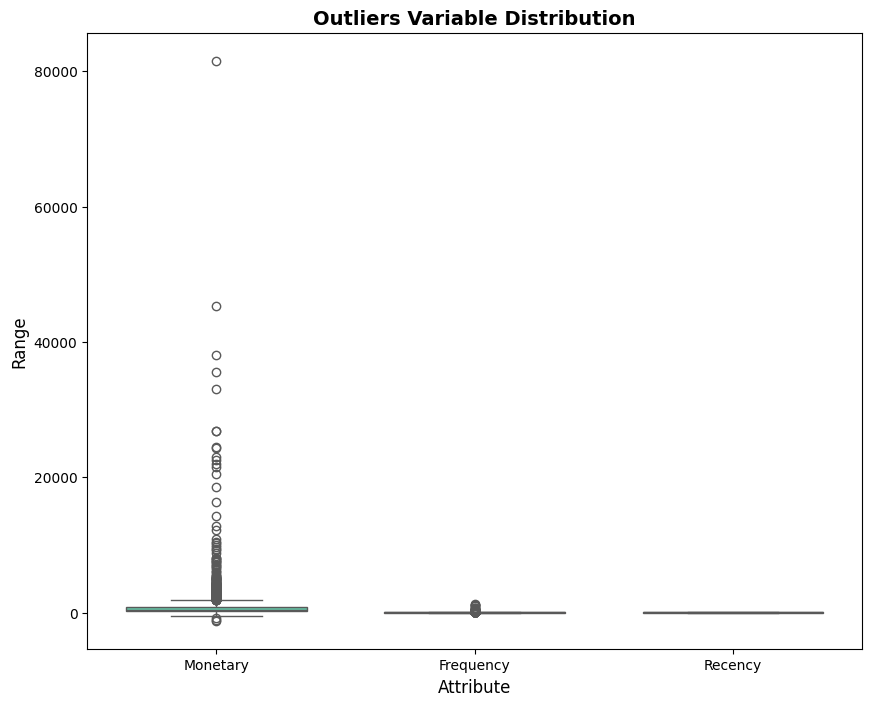

In [16]:
# outlier analaysis of amount frequency and recency
attribute= ['Monetary', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10, 8]
sns.boxplot(data=df[attribute],orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight='bold')
plt.ylabel("Range", fontsize = 12)
plt.xlabel("Attribute", fontsize = 12)


In [17]:
  # removing outliers for monetary
  q1= df['Monetary'].quantile(0.25)
  q3= df['Monetary'].quantile(0.75)
  iqr= q3-q1
  lower_bound= q1-1.5*iqr
  upper_bound= q3+1.5*iqr
  df= df[(df.Monetary> lower_bound) & (df.Monetary< upper_bound)]

  # removing outliers for frequency
  q1= df['Frequency'].quantile(0.25)
  q3= df['Frequency'].quantile(0.75)
  iqr= q3-q1
  lower_bound= q1-1.5*iqr
  upper_bound= q3+1.5*iqr
  df= df[(df.Frequency> lower_bound) & (df.Frequency< upper_bound)]

  #removing outlier for recency
  q1= df['Recency'].quantile(0.25)
  q3= df['Recency'].quantile(0.75)
  iqr= q3-q1
  lower_bound= q1-1.5*iqr
  upper_bound= q3+1.5*iqr
  df= df[(df.Recency> lower_bound) & (df.Recency< upper_bound)]


In [18]:
# scaling the features

scaler= StandardScaler()
df_scaled= scaler.fit_transform(df[['Monetary', 'Frequency', 'Recency']])
df_scaled= pd.DataFrame(df_scaled)
df_scaled.columns= ['Monetary', 'Frequency', 'Recency']
df_scaled.shape

(2035, 3)

In [20]:
kmeans.labels_

array([2, 4, 0, ..., 3, 2, 3], dtype=int32)

In [21]:
set(kmeans.labels_ )

{0, 1, 2, 3, 4}

Text(0.5, 0, 'Number of Clusters')

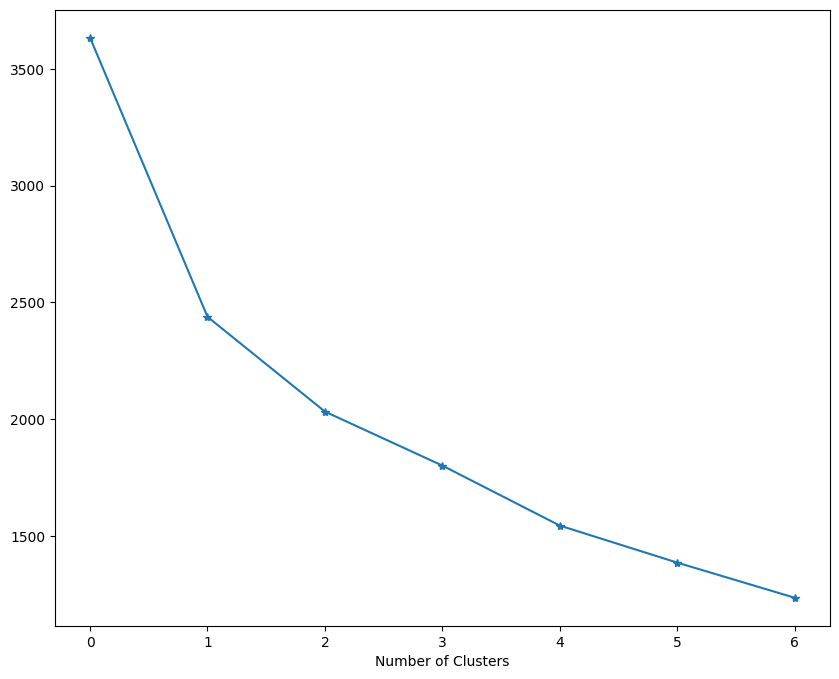

In [22]:
# elbow curve for right number of clusters
ssd=[]
range_n_clusters=[2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
  kmeans= KMeans(n_clusters= num_clusters, max_iter=50)
  kmeans.fit(df_scaled)
  ssd.append(kmeans.inertia_)
# plot SSD for each n_clusters
plt.plot(ssd, '*-')
plt.xlabel('Number of Clusters')

In [23]:
# final model with n= 3
kmeans= KMeans(n_clusters= 3, max_iter=50)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [24]:
# define filename for pickle file
filename= 'kmeans_model.pkl'
# open file in write mode
import pickle
pickle.dump(kmeans, open(filename, 'wb'))

with open(filename, 'rb') as file:
  kmeans= pickle.load(file)

# close the file
file.close()

pickle.dump(kmeans, open(filename, 'wb'))